<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/Trigram_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv                               
import re                                       
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support 
from random import shuffle
import numpy as np
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def parseReview(reviewLine): 
    Post=reviewLine[3] 
    Mental_Health_Condition=reviewLine[6]
    

    return (Post,Mental_Health_Condition)

In [ ]:
def preProcess(text):
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) 
    text = re.sub(r"([.,;:!?'\"“\(])(\w)", r"\1 \2", text)
    text = re.sub(r"(\S)\1\1+",r"\1\1\1", text)
    text = re.sub(r'[^A-Za-z0-9 ]+','', text)  # remove non- english characters such as Äö 
     
    tokens = text.split(" ")
    tokens = [t.lower() for t in tokens]
    pairs = [ " ".join(pair) for pair in nltk.ngrams(tokens,3)]
    #pairs = [ " ".join(pair) for pair in nltk.bigrams(tokens)]
    return pairs


In [ ]:
featureDict = {} 

def toFeatureVector(lemmatized_tokens):
    v = {}
    for t in lemmatized_tokens:
        try:
            featureDict[t] += 1
        except KeyError:            
            featureDict[t] = 1
        try:
            v[t] += (1.0/len(lemmatized_tokens))
        except KeyError:
            v[t] = (1.0/len(lemmatized_tokens))
    return v

In [ ]:
# Downloading datasets 
rawTrainData=[]
with open("/content/drive/MyDrive/mental_health_data/full_mental_health_df_train.csv") as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Post,Mental_Health_Condition) = parseReview(line)
        rawTrainData.append((Post,Mental_Health_Condition))
        
rawTestData=[]
with open('/content/drive/MyDrive/mental_health_data/full_mental_health_df_test.csv') as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Post,Mental_Health_Condition) = parseReview(line)
        rawTestData.append((Post,Mental_Health_Condition))

testData=[]
trainData=[]

for (Mental_Health_Condition,Post) in rawTrainData:
        #trainData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        trainData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

for (Mental_Health_Condition,Post) in rawTestData:
        #testData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        testData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

In [ ]:
testData[600]

({' and almost': 0.0035460992907801418,
  ' and i': 0.0035460992907801418,
  ' but i': 0.0035460992907801418,
  ' has anyone': 0.0035460992907801418,
  ' he broke': 0.0035460992907801418,
  ' how can': 0.0035460992907801418,
  ' how do': 0.0035460992907801418,
  ' i ': 0.0035460992907801418,
  ' i can': 0.0035460992907801418,
  ' i caught': 0.0035460992907801418,
  ' i have': 0.0035460992907801418,
  ' i lost': 0.0035460992907801418,
  ' in addition': 0.0035460992907801418,
  ' m a': 0.0035460992907801418,
  ' or does': 0.0035460992907801418,
  ' s been': 0.0035460992907801418,
  ' s just': 0.0035460992907801418,
  ' s length': 0.0035460992907801418,
  ' s lives': 0.0035460992907801418,
  ' subsequently ': 0.0035460992907801418,
  ' t want': 0.0035460992907801418,
  ' though they': 0.0035460992907801418,
  ' ve basically': 0.0035460992907801418,
  ' ve long': 0.0035460992907801418,
  ' ve since': 0.0035460992907801418,
  '99 of it': 0.0035460992907801418,
  'a bit there': 0.00354609929

In [ ]:
# Lenght of the datasets
print("Now  %d trainData, %d testData" % ( len(trainData), len(testData)))

# Number of features
print("Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')

Now  122073 trainData, 30893 testData
Training Samples: 
122073
Features: 
8913008


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# Training and validating classifier
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline = Pipeline([('tfidf', TfidfTransformer()),('svc', LinearSVC(penalty='l2', loss='hinge', dual=True, tol=0.0001, C=1, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None))])
    return SklearnClassifier(pipeline).train(trainData)


In [ ]:
# Predicting labels given a classifier
def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

In [ ]:
# Cross-Validate
def crossValidate(dataset, folds):
    shuffle(dataset)
    results = []
    foldSize = int(len(dataset)/folds)
    
    for i in range(0,len(dataset),int(foldSize)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+foldSize))
        myTestData = dataset[i:i+foldSize]
        myTrainData = dataset[:i] + dataset[i+foldSize:]
        classifier = trainClassifier(myTrainData)
        y_true = [x[1] for x in myTestData]
        y_pred = predictLabels(myTestData, classifier)
        results.append(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
        
    print(zip(*results))
    avgResults = [np.mean([x[0] for x in results]),
                  np.mean([x[1] for x in results]),
                  np.mean([x[2] for x in results])
                ]
    return avgResults

In [ ]:
cv_results = crossValidate(trainData, 10)
print(cv_results)

Fold start on items 0 - 12207
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 12207 - 24414
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 24414 - 36621
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 36621 - 48828
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 48828 - 61035
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 61035 - 73242
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 73242 - 85449
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 85449 - 97656
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 97656 - 109863
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 109863 - 122070
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Fold start on items 122070 - 134277
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.7538387180723423, 0.7452058059086814, 0.7311606592300496]


In [ ]:
functions_complete = True  
if functions_complete:
    print(testData[0])   
    classifier = trainClassifier(trainData)  
    testTrue = [t[1] for t in testData]   
    testPred = predictLabels(testData, classifier)  
    finalScores = precision_recall_fscore_support(testTrue, testPred, average='weighted') 
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % finalScores[:3])

({'rant about anxiety': 0.0024154589371980675, 'about anxiety meds': 0.0024154589371980675, 'anxiety meds ': 0.0024154589371980675, 'meds  i': 0.0024154589371980675, ' i ': 0.007246376811594202, 'i  ve': 0.0024154589371980675, ' ve been': 0.004830917874396135, 've been self': 0.0024154589371980675, 'been self medicating': 0.0024154589371980675, 'self medicating with': 0.0024154589371980675, 'medicating with benzodiazepines': 0.0024154589371980675, 'with benzodiazepines ': 0.0024154589371980675, 'benzodiazepines  valium': 0.0024154589371980675, ' valium ': 0.0024154589371980675, 'valium  first': 0.0024154589371980675, ' first it': 0.0024154589371980675, 'first it started': 0.0024154589371980675, 'it started with': 0.0024154589371980675, 'started with cannabis': 0.0024154589371980675, 'with cannabis ': 0.0024154589371980675, 'cannabis  a': 0.0024154589371980675, ' a very': 0.0024154589371980675, 'a very no': 0.0024154589371980675, 'very no nonsense': 0.0024154589371980675, 'no nonsense s

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done training!
Precision: 0.730508
Recall: 0.721490
F Score:0.707147


In [ ]:
print(metrics.classification_report(testTrue, testPred))

                 precision    recall  f1-score   support

        anxiety       0.75      0.68      0.71      4342
  bipolarreddit       0.74      0.04      0.08       340
     conspiracy       0.76      0.81      0.78      1498
     depression       0.67      0.83      0.74     11715
        fitness       0.84      0.93      0.88      3478
     meditation       0.94      0.64      0.76       946
      parenting       0.86      0.84      0.85      1979
personalfinance       0.96      0.55      0.70       337
           ptsd       0.86      0.15      0.26       451
  schizophrenia       0.91      0.17      0.29       505
   suicidewatch       0.63      0.49      0.55      5052
       teaching       0.94      0.37      0.53       250

       accuracy                           0.72     30893
      macro avg       0.82      0.54      0.59     30893
   weighted avg       0.73      0.72      0.71     30893



In [ ]:
labels=['conspiracy','depression','anxiety','bipolarreddit','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
confusion = confusion_matrix(testTrue, testPred,labels)

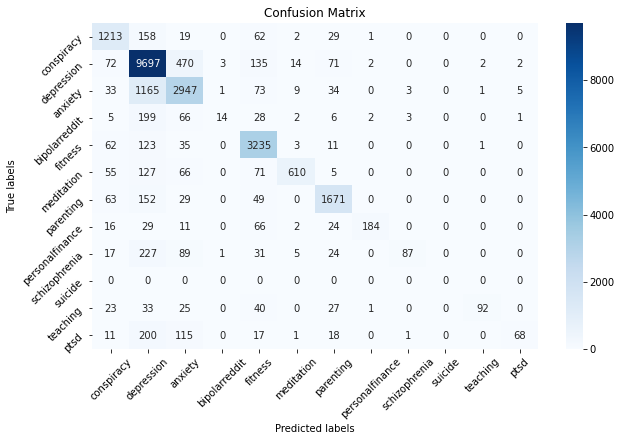

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels( labels,rotation=45); ax.set_yticklabels(labels,rotation=45);